<h3>Importing Libraries</h3>
<p>In this cell, the necessary Python libraries such as pandas, yfinance, and datetime are imported for data handling and time series analysis.</p>

In [24]:
import pandas as pd
#import yfinance as yf
import datetime
from datetime import date, timedelta
import matplotlib.pyplot as plt;
import plotly.express as px;
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error


<h3>Data Collection</h3>


In [25]:
today = date.today()
print("TODAYS DATE:",today)
end_date = today.strftime("%Y-%m-%d")

d1 = date.today() - timedelta(days=1460)
start_date = d1.strftime("%Y-%m-%d")

data = pd.read_csv('D:ElliotSystems/zomato_stock_data.csv')
#data["Date"] = data.index
df = data[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]
df.reset_index(drop=True, inplace=True)
print(df.head(5))

TODAYS DATE: 2024-12-17
         Date        Open        High         Low       Close   Adj Close  \
0  23-07-2021  116.000000  138.899994  115.000000  126.000000  126.000000   
1  26-07-2021  126.349998  143.750000  125.300003  140.649994  140.649994   
2  27-07-2021  141.699997  147.800003  127.750000  132.899994  132.899994   
3  28-07-2021  131.000000  135.000000  123.550003  131.199997  131.199997   
4  29-07-2021  134.949997  144.000000  132.199997  141.550003  141.550003   

      Volume  
0  694895290  
1  249723854  
2  240341900  
3  159793731  
4  117973089  


In [26]:
print(df.tail())

           Date        Open        High         Low       Close   Adj Close  \
693  15-05-2024  188.800003  193.399994  183.149994  192.000000  192.000000   
694  16-05-2024  192.899994  195.850006  189.000000  195.199997  195.199997   
695  17-05-2024  195.149994  196.000000  193.100006  194.850006  194.850006   
696  21-05-2024  194.399994  196.500000  188.750000  189.100006  189.100006   
697  22-05-2024  190.000000  190.000000  183.350006  185.500000  185.500000   

       Volume  
693  44772997  
694  35478593  
695  20841351  
696  33453174  
697  40354936  


<h3>Data Preprocessing</h3>
<p>Here, the data is further preprocessed. It narrows down the dataset to include only the 'Date' and 'Close' columns. The code also resets the index for data consistency.</p>

In [27]:
df = df[["Date", "Close"]]
print(df.head())

         Date       Close
0  23-07-2021  126.000000
1  26-07-2021  140.649994
2  27-07-2021  132.899994
3  28-07-2021  131.199997
4  29-07-2021  141.550003


<h3>Data Visualization</h3>
<p>This cell uses the matplotlib library to create a time series plot of the closing prices of zomato's stock. style is applied for visualization.</p>

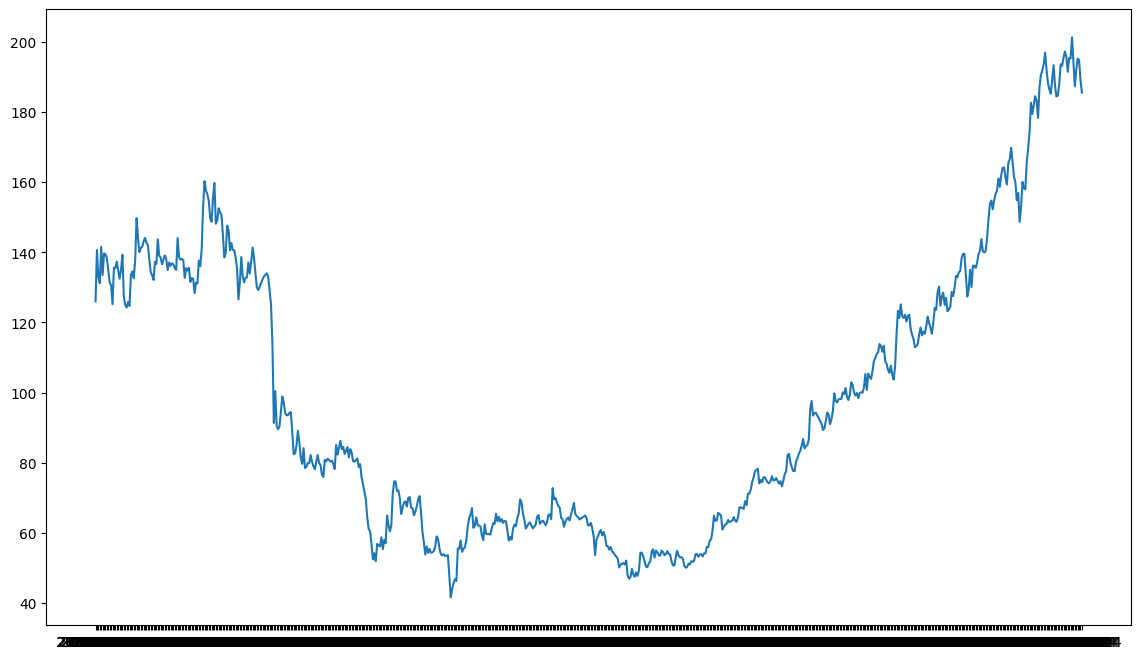

In [28]:
import matplotlib.pyplot as plt
plt.style.use('default')
plt.figure(figsize=(14, 8))
plt.plot(df["Date"], df["Close"])

<h3>Time Series Decomposition</h3>
<p>The statsmodels library is utilized for seasonal decomposition. This cell separates the trend, seasonality, and residual components of the stock prices.</p>

<Figure size 640x480 with 0 Axes>

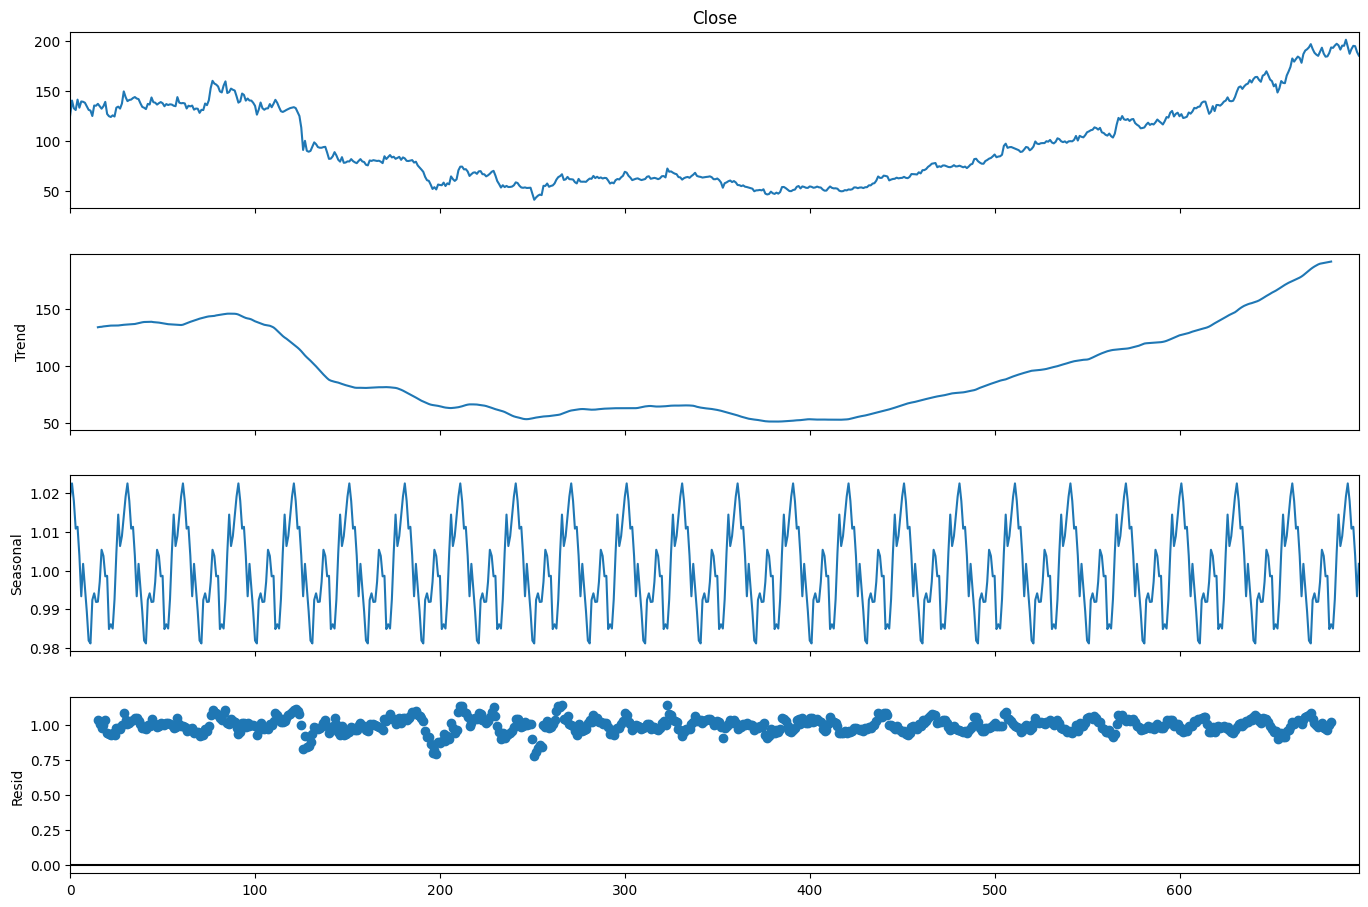

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df["Close"], 
                            model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 10)

In [30]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [31]:
adf_test(df['Close'])

ADF Statistics: -0.055582613945341294
p- value: 0.9536868667248083
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [32]:
df['First Difference'] = df['Close']-df['Close'].shift(1)
df.head()

,Date,Close,First Difference
0,23-07-2021,126.000000,NaN
1,26-07-2021,140.649994,14.649994
2,27-07-2021,132.899994,-7.750000
3,28-07-2021,131.199997,-1.699997
4,29-07-2021,141.550003,10.350006


In [33]:
adf_test(df['First Difference'].dropna())

ADF Statistics: -27.05623212942083
p- value: 0.0
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


<Axes: >

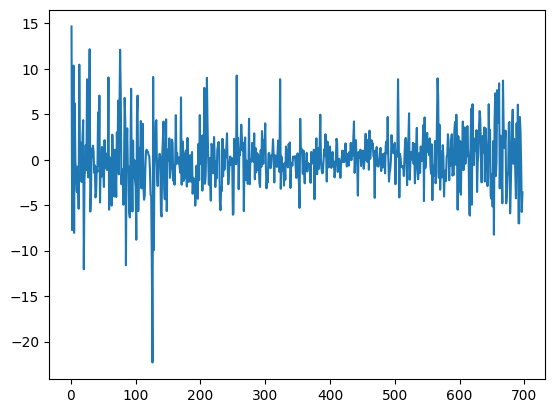

In [34]:
df['First Difference'].dropna().plot()

<h3>AutoCorrelation Plot</h3>
<p>AutoCorrelation is visualized using the pandas library, helping identify potential time series patterns.</p>

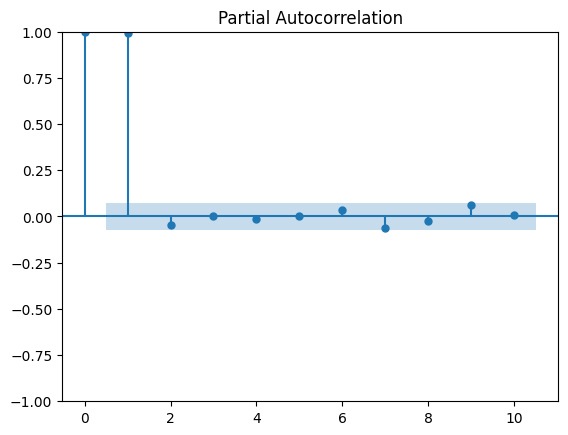

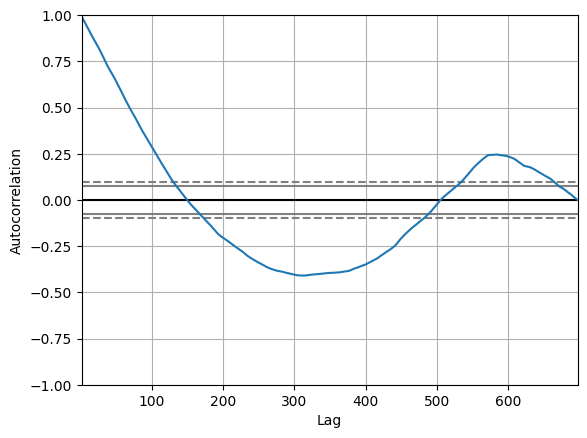

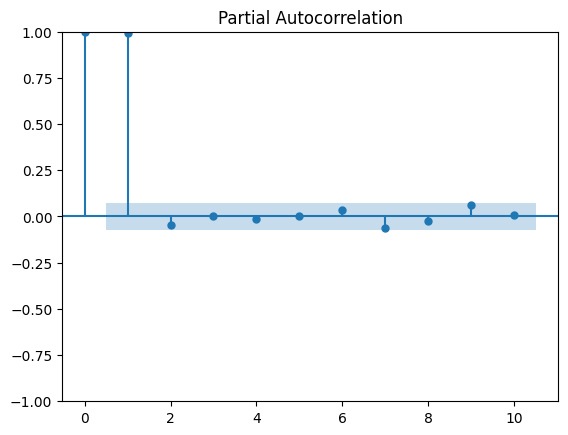

In [35]:

pd.plotting.autocorrelation_plot(df["Close"])
# plt.figure(figsize=(14,7))
# plot_acf(df['Close'])
# plt.title('Autocorrelation Function ACF plot')
# plt.show()
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df["Close"], lags = 10)


<h3>Partial AutoCorrelation Plot</h3>
<p>This cell generates the Partial AutoCorrelation Function (PACF) plot to aid in parameter selection for the ARIMA model.</p>

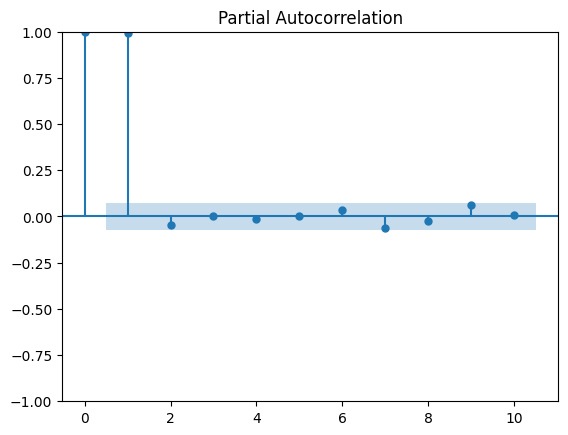

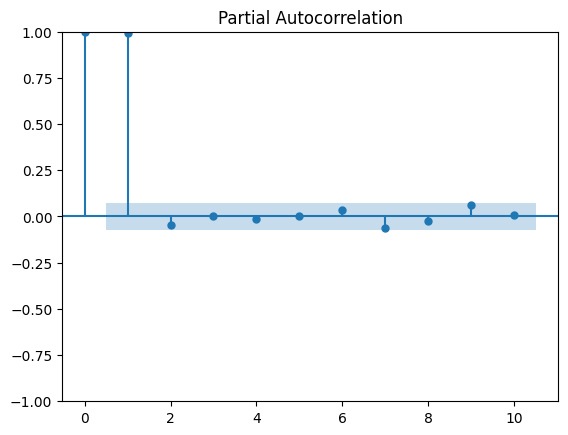

In [36]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df["Close"], lags = 10)

In [37]:

df['First Difference'] = df['Close']-df['Close'].shift(1)
print(df['First Difference'])

0            NaN
1      14.649994
2      -7.750000
3      -1.699997
4      10.350006
         ...    
693     4.699997
694     3.199997
695    -0.349991
696    -5.750000
697    -3.600006
Name: First Difference, Length: 698, dtype: float64


In [38]:
#lets run arima with pmdarima
from pmdarima.arima  import auto_arima
model = auto_arima (df['Close'],start_P= 2, start_q= 2, max_p=5, max_q =5, start_p=0, seasonal=True,d =1, D =1, trace=True, error_action='ignore', suppress_warnings=True)
model = auto_arima(df['Close'], seasonal=True,suppress_warnings=True)
print(model.summary())



Performing stepwise search to minimize aic
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3617.118, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3615.261, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3617.145, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3617.131, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3613.749, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3618.704, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.427 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  698
Model:               SARIMAX(5, 2, 0)   Log Likelihood               -1855.497
Date:                Tue, 17 Dec 2024   AIC                           3722.993
Time:                        01:57:33   BIC                           3750.265
Sample:                             0   HQIC                          3733.538
          

<h3>ARIMA Modeling</h3>
<p>The ARIMA (AutoRegressive Integrated Moving Average) model is constructed here. It fits the model to the 'Close' prices with specified parameters and prints a summary of the model.</p>

In [2]:
p, d, q = 10,2,8
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df["Close"], order=(p,d,q))  
fitted = model.fit()  
print(fitted.summary())

NameError: name 'df' is not defined

<h3>ARIMA Predictions</h3>
<p>This cell generates predictions using the ARIMA model and prints the results.</p>

In [40]:
predictions = fitted.predict()
print(predictions)

0        0.000000
1      125.999959
2      140.204884
3      132.047205
4      132.552201
          ...    
693    186.961887
694    193.053728
695    196.806204
696    195.480105
697    188.213521
Name: predicted_mean, Length: 698, dtype: float64


<h3>SARIMAX Predictions</h3>
<p>Predictions for future stock prices are generated using the SARIMAX model.</p>

In [41]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(data['Close'],
                                order=(p, d, q),
                                seasonal_order=(p, d, q, 12))
model=model.fit()
print(model.summary()) 

ValueError: Invalid model: moving average lag(s) {12} are in both the seasonal and non-seasonal moving average components.

<h3>Data and Predictions Visualization</h3>
<p>The cell plots the training data and the predictions on a single graph for visual comparison.</p>

First 15 days

In [19]:
df = df[["Date","Close"]]
print(df.tail(30))


           Date       Close
668  05-04-2024  190.500000
669  08-04-2024  191.800003
670  09-04-2024  193.699997
671  10-04-2024  196.899994
672  12-04-2024  192.100006
673  15-04-2024  188.300003
674  16-04-2024  186.449997
675  18-04-2024  185.199997
676  19-04-2024  189.199997
677  22-04-2024  193.350006
678  23-04-2024  187.449997
679  24-04-2024  184.399994
680  25-04-2024  184.699997
681  26-04-2024  188.100006
682  29-04-2024  193.600006
683  30-04-2024  193.149994
684  02-05-2024  195.449997
685  03-05-2024  197.250000
686  06-05-2024  195.699997
687  07-05-2024  191.449997
688  08-05-2024  195.449997
689  09-05-2024  195.250000
690  10-05-2024  201.300003
691  13-05-2024  194.300003
692  14-05-2024  187.300003
693  15-05-2024  192.000000
694  16-05-2024  195.199997
695  17-05-2024  194.850006
696  21-05-2024  189.100006
697  22-05-2024  185.500000


Next 15 days which prices will be predicted (RESULT)

In [20]:
df = df[["Date","Close"]]
print(df.tail(15))

           Date       Close
683  30-04-2024  193.149994
684  02-05-2024  195.449997
685  03-05-2024  197.250000
686  06-05-2024  195.699997
687  07-05-2024  191.449997
688  08-05-2024  195.449997
689  09-05-2024  195.250000
690  10-05-2024  201.300003
691  13-05-2024  194.300003
692  14-05-2024  187.300003
693  15-05-2024  192.000000
694  16-05-2024  195.199997
695  17-05-2024  194.850006
696  21-05-2024  189.100006
697  22-05-2024  185.500000


In [ ]:
# Generate predictions using the SARIMAX model

# start_date = (df["Date"].iloc[-1] + pd.Timedelta(days=1)).strftime("%Y-%m-%d")
# date_range = pd.date_range(start=start_date, periods=50, freq="D")
# predictions = model.predict(len(df), len(df) + 49)
                            
# predictions.index = date_range
# print(predictions)

start_date = '2024-04-30'
date_range =  pd.date_range(start=start_date, periods = 15, freq="D")
predictions = model.predict(len(df),len(df)+14)
predictions.index = date_range
print("predictions:")
print(predictions)

predictions:
2024-04-30    185.974356
2024-05-01    185.727845
2024-05-02    188.316050
2024-05-03    187.193539
2024-05-04    185.728432
2024-05-05    188.016556
2024-05-06    186.875501
2024-05-07    186.998531
2024-05-08    188.264537
2024-05-09    188.109987
2024-05-10    187.945203
2024-05-11    188.694054
2024-05-12    188.099206
2024-05-13    187.670631
2024-05-14    187.863575
Freq: D, Name: predicted_mean, dtype: float64


C:\Users\valla\AppData\Local\Temp\ipykernel_23088\1189558804.py:10: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["Date"] = pd.to_datetime(df["Date"])


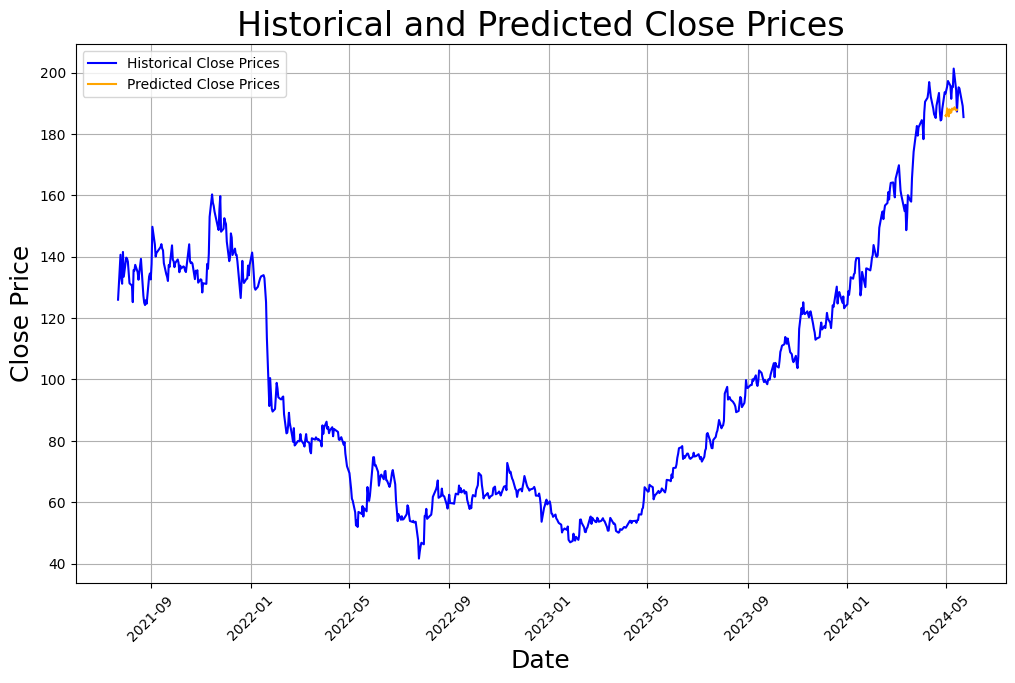

In [22]:
# plt.figure(figsize=(20, 10))
# plt.plot(df["Date"], df["Close"])
# plt.plot(predictions)


start_date = pd.to_datetime("2024-04-30")
date_range = pd.date_range(start=start_date, periods=15, freq="D")
predictions = model.predict(len(df), len(df) + 14)
predictions.index = date_range
df["Date"] = pd.to_datetime(df["Date"])
plt.figure(figsize=(12, 7))
plt.plot(df["Date"], df["Close"], label='Historical Close Prices', color='blue')
plt.plot(predictions.index, predictions, label='Predicted Close Prices', color='orange')
plt.title('Historical and Predicted Close Prices', fontsize=24)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.xticks(rotation=45)  
plt.legend()
plt.grid()
plt.show()